## Importando Bibliotecas ##

In [505]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import numpy as np
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import math
from statsmodels.tsa.seasonal import seasonal_decompose

## Observando a estacionariedade das séries ##

## 1. Balança Comercial ##

In [506]:
balanca = pd.read_excel('balanca_comercial.xls', parse_dates=['Data'])

In [507]:
balanca

,Data,"Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -"
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [508]:
balanca_novo = balanca.rename(columns = {'Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -':'Saldo Balanca'})
balanca_novo

,Data,"Balanço de pagamentos - balança comercial - saldo - US$ (milhões) - Banco Central do Brasil, Balanço de Pagamentos (BPM6) (BCB / BP (BPM6)) - BPAG12_BC12 -"
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [509]:
balanca_novo = balanca_novo.set_axis(['Data', 'Saldo Balanca'], axis='columns')

In [510]:
balanca_novo

,Data,Saldo Balanca
0,1995-01-01,-398.728132
1,1995-02-01,-1151.625706
2,1995-03-01,-1019.483914
3,1995-04-01,-565.690024
4,1995-05-01,-781.699265
...,...,...
336,2023-01-01,894.689159
337,2023-02-01,2262.890102
338,2023-03-01,9340.252047
339,2023-04-01,6942.439554


In [511]:
balanca_novo.dtypes

Data             datetime64[ns]
Saldo Balanca           float64
dtype: object

In [512]:
balanca_novo['Data'] = pd.to_datetime(balanca_novo['Data'], format='%Y.%m').dt.strftime('%Y-%m')
balanca_novo

,Data,Saldo Balanca
0,1995-01,-398.728132
1,1995-02,-1151.625706
2,1995-03,-1019.483914
3,1995-04,-565.690024
4,1995-05,-781.699265
...,...,...
336,2023-01,894.689159
337,2023-02,2262.890102
338,2023-03,9340.252047
339,2023-04,6942.439554


In [513]:
balanca_novo.dtypes

Data              object
Saldo Balanca    float64
dtype: object

In [514]:
balanca_novo = balanca_novo.set_index('Data')

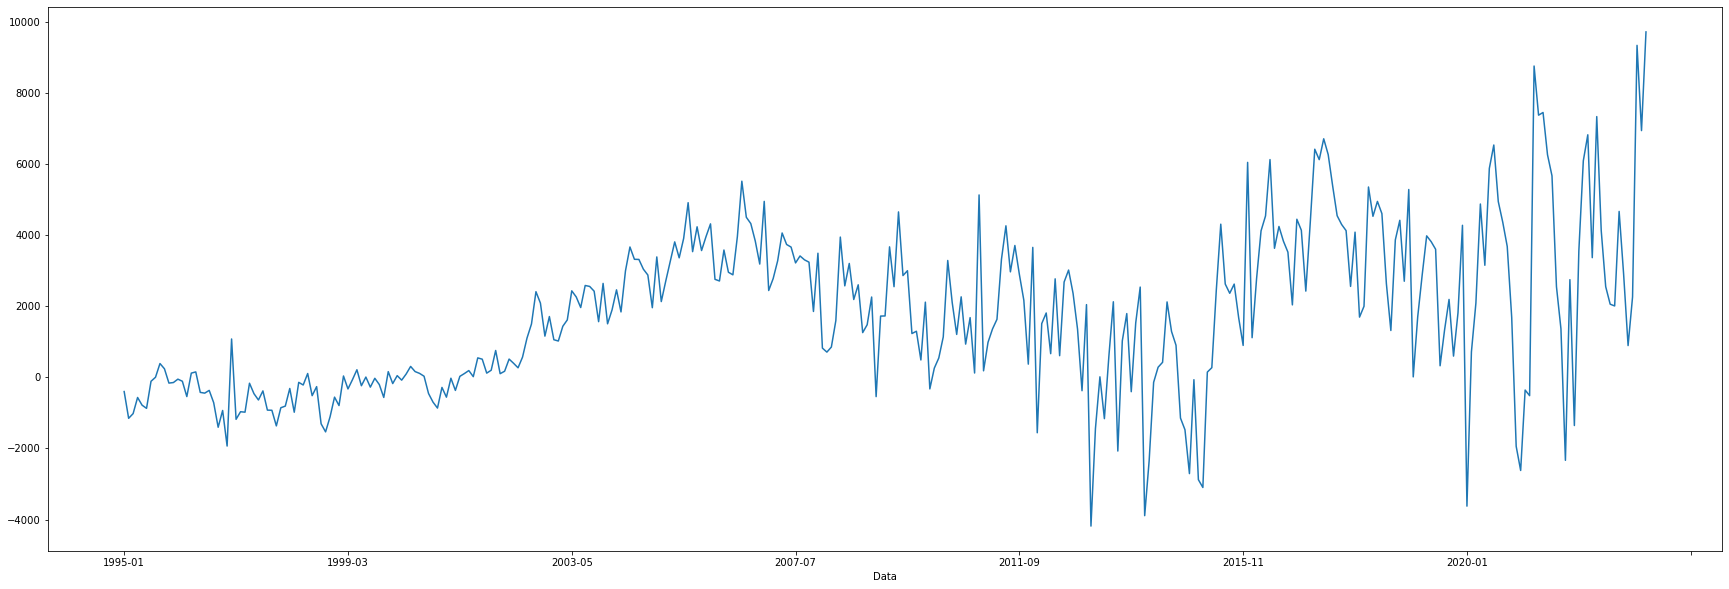

In [515]:
fig, axs = plt.subplots(figsize=(30,10))
balanca_novo['Saldo Balanca'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Implementando teste ADF ##

In [516]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

## Implementando teste KPSS ##

In [517]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Testando a série de balança comercial ##

In [518]:
adf_test(balanca_novo["Saldo Balanca"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.398814
p-value                          0.582845
#Lags Used                      14.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64


### Para o teste ADF, a hipótese nula é de uma raíz unitária, logo, para o valor da estatística do teste de -1.39, falhamos em rejeitar a hipótese nula, dado que estamos fora da região crítica. Assim, podemos concluir que a séria tem uma raíz unitária, a partir desse teste. ###

In [519]:
kpss_test(balanca_novo['Saldo Balanca'])

Results of KPSS Test:
Test Statistic            1.409952
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, a hipótese nula é de que a série não tem uma raíz unitária. Neste caso, a estatística do teste de 1.41 nós rejeitamos a hipótese nula, concluindo que a série tem uma raiz unitária. Logo, é não estacionária. ###


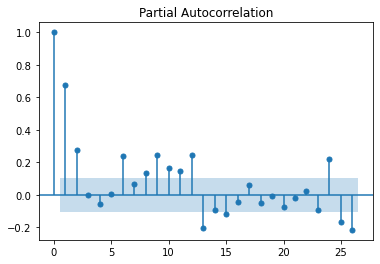

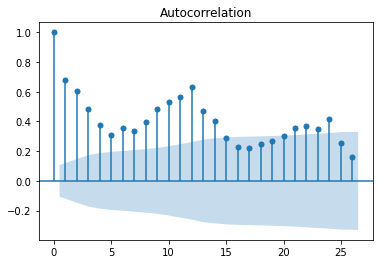

In [520]:
pacf_balanca = plot_pacf(balanca_novo['Saldo Balanca'])
acf_balanca = plot_acf(balanca_novo['Saldo Balanca'])

## Aqui, a partir da função de autocorrelação, é possível observar um possível comportamento sazonal da série, sendo assim, irei fazer o processo de retirar a sazonalidade da série e refazer os testes ##

In [521]:
result=seasonal_decompose(balanca_novo['Saldo Balanca'], model='additive', period=12)

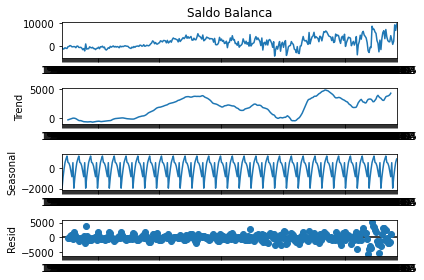

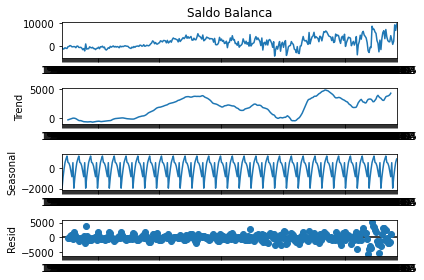

In [522]:
result.plot()

In [523]:
sazonalidade = result.seasonal
sazonalidade

Data
1995-01   -1958.478799
1995-02    -900.706367
1995-03    -121.393697
1995-04     519.177787
1995-05     859.050790
              ...     
2023-01   -1958.478799
2023-02    -900.706367
2023-03    -121.393697
2023-04     519.177787
2023-05     859.050790
Name: seasonal, Length: 341, dtype: float64

## Removendo a Sazonalidade ##

In [524]:
balanca_novo_dess = balanca_novo['Saldo Balanca'] - sazonalidade
balanca_novo_dess 


Data
1995-01    1559.750667
1995-02    -250.919339
1995-03    -898.090217
1995-04   -1084.867811
1995-05   -1640.750055
              ...     
2023-01    2853.167958
2023-02    3163.596469
2023-03    9461.645744
2023-04    6423.261767
2023-05    8859.681790
Length: 341, dtype: float64

In [525]:
df_balanca_dess = balanca_novo_dess.to_frame()

In [526]:
df_balanca_dess = df_balanca_dess.set_axis(['Saldo'], axis='columns')

In [527]:
df_balanca_dess

,Saldo
Data,
1995-01,1559.750667
1995-02,-250.919339
1995-03,-898.090217
1995-04,-1084.867811
1995-05,-1640.750055
...,...
2023-01,2853.167958
2023-02,3163.596469
2023-03,9461.645744


In [528]:
df_balanca_dess.index = pd.to_datetime(df_balanca_dess.index)

In [529]:
import datetime
data_inicio = datetime.datetime(2000, 1, 1)
data_final = datetime.datetime(2020, 1, 1)

df_balanca_dess_filtrado = df_balanca_dess[(data_inicio <= df_balanca_dess.index) &  (data_final > df_balanca_dess.index)]

In [530]:
df_balanca_dess_filtrado

,Saldo
Data,
2000-01-01,1784.442181
2000-02-01,949.372969
2000-03-01,43.387843
2000-04-01,-424.838476
2000-05-01,-551.103384
...,...
2019-08-01,876.522803
2019-09-01,2018.006747
2019-10-01,953.568404


## Testando a série da balança comercial dessazonalidada ##

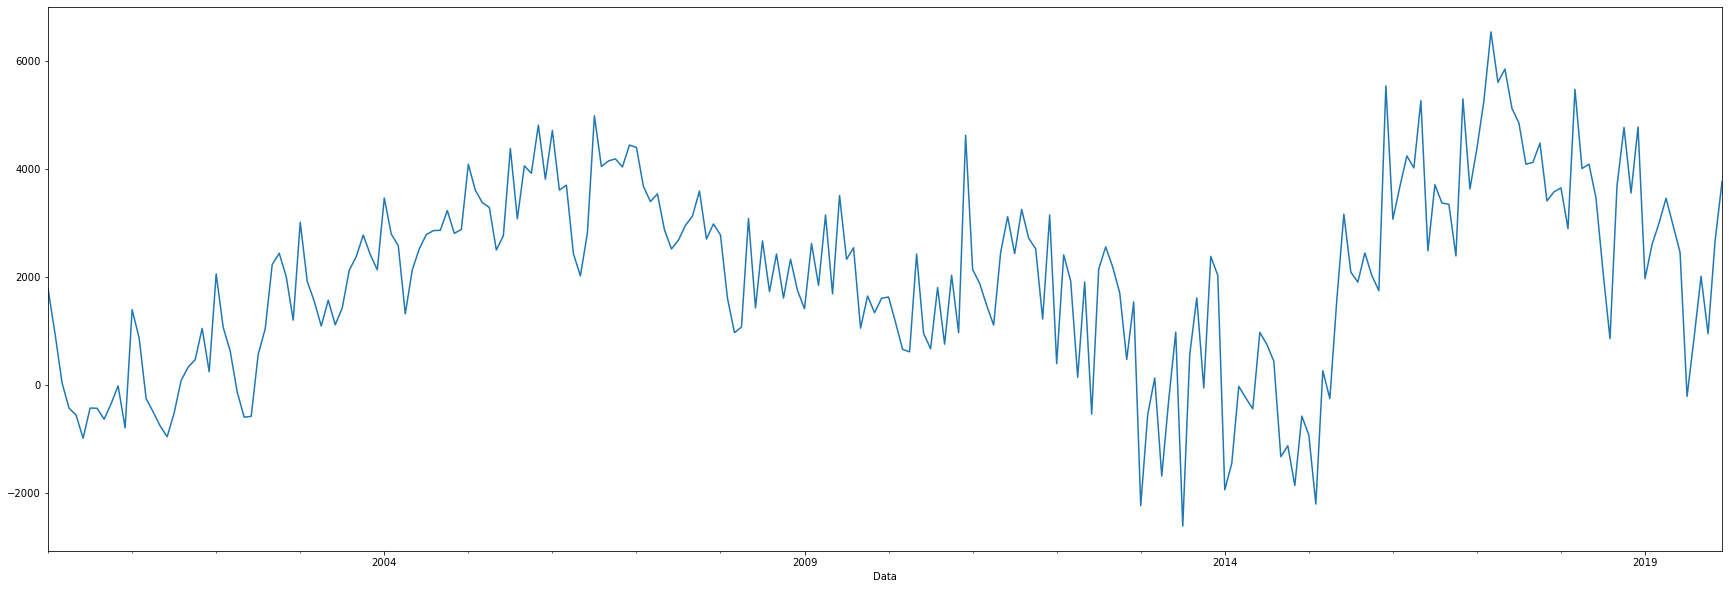

In [531]:
fig, axs = plt.subplots(figsize=(30,10))
df_balanca_dess_filtrado['Saldo'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Funções de autocorrelação ##

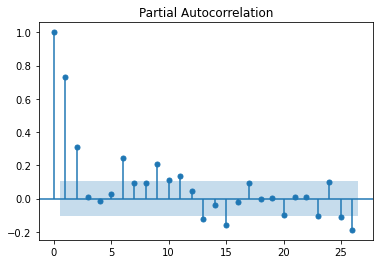

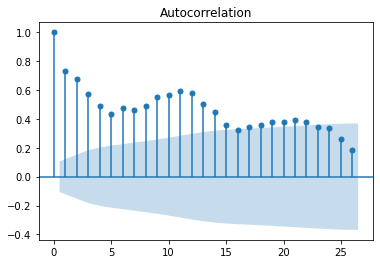

In [532]:
pacf_balanca_dess_filtrado = plot_pacf(df_balanca_dess['Saldo'])
acf_balanca_dess_filtrado = plot_acf(df_balanca_dess['Saldo'])

In [533]:
adf_test(df_balanca_dess_filtrado["Saldo"])
kpss_test(df_balanca_dess_filtrado['Saldo'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.705846
p-value                          0.073032
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Results of KPSS Test:
Test Statistic           0.301995
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### A série sem a sasonalidade continua apontando a presença da raíz unitária, a partir dos testes ADF e KPSS ###

## 2. Cambio ##

In [534]:
cambio = pd.read_csv('cambio.csv', parse_dates=['Data'], sep = ';')
cambio

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - fim período - R$ - Banco Central do Brasil, Boletim, Seção Balanço de Pagamentos (Bacen / Boletim / BP) - BM12_ERCF12",Unnamed: 2
0,1953-01-01,"6,68363636363636E-15",NaN
1,1953-02-01,"1,49090909090909E-14",NaN
2,1953-03-01,"1,49090909090909E-14",NaN
3,1953-04-01,"1,41818181818182E-14",NaN
4,1953-05-01,"1,56363636363636E-14",NaN
...,...,...,...
840,2023-01-01,"5,0987",NaN
841,2023-02-01,"5,2072",NaN
842,2023-03-01,"5,0798",NaN
843,2023-04-01,"5,0001",NaN


In [535]:
cambio

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - fim período - R$ - Banco Central do Brasil, Boletim, Seção Balanço de Pagamentos (Bacen / Boletim / BP) - BM12_ERCF12",Unnamed: 2
0,1953-01-01,"6,68363636363636E-15",NaN
1,1953-02-01,"1,49090909090909E-14",NaN
2,1953-03-01,"1,49090909090909E-14",NaN
3,1953-04-01,"1,41818181818182E-14",NaN
4,1953-05-01,"1,56363636363636E-14",NaN
...,...,...,...
840,2023-01-01,"5,0987",NaN
841,2023-02-01,"5,2072",NaN
842,2023-03-01,"5,0798",NaN
843,2023-04-01,"5,0001",NaN


In [536]:
cambio = cambio.drop("Unnamed: 2", axis = 1)

In [537]:
cambio = cambio.rename(columns={cambio.columns[1]: 'Cambio'})

In [538]:
cambio

,Data,Cambio
0,1953-01-01,"6,68363636363636E-15"
1,1953-02-01,"1,49090909090909E-14"
2,1953-03-01,"1,49090909090909E-14"
3,1953-04-01,"1,41818181818182E-14"
4,1953-05-01,"1,56363636363636E-14"
...,...,...
840,2023-01-01,"5,0987"
841,2023-02-01,"5,2072"
842,2023-03-01,"5,0798"
843,2023-04-01,"5,0001"


In [539]:
cambio['Cambio'].describe()

count       845
unique      703
top       8E-13
freq         15
Name: Cambio, dtype: object

In [540]:
import datetime
data_inicio = datetime.datetime(2000, 1, 1)
data_final = datetime.datetime(2020, 1, 1)

cambio_filtrado = cambio[(data_inicio <= cambio["Data"]) &  (data_final > cambio["Data"])]

In [541]:
cambio_filtrado['Data'] = pd.to_datetime(cambio_filtrado['Data'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

C:\Users\luizv\AppData\Local\Temp/ipykernel_76832/515219951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cambio_filtrado['Data'] = pd.to_datetime(cambio_filtrado['Data'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')


In [542]:
cambio_filtrado

,Data,Cambio
564,2000-01-01,"1,8016"
565,2000-02-01,"1,7677"
566,2000-03-01,"1,7465"
567,2000-04-01,"1,8059"
568,2000-05-01,"1,8258"
...,...,...
799,2019-08-01,"4,1379"
800,2019-09-01,"4,1638"
801,2019-10-01,"4,0035"
802,2019-11-01,"4,2234"


In [543]:
cambio_filtrado.dtypes

Data      object
Cambio    object
dtype: object

In [544]:
cambio_filtrado['Cambio'] = cambio_filtrado['Cambio'].apply(lambda x: float(x.replace(".","").replace(",",".")))

C:\Users\luizv\AppData\Local\Temp/ipykernel_76832/2452852971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cambio_filtrado['Cambio'] = cambio_filtrado['Cambio'].apply(lambda x: float(x.replace(".","").replace(",",".")))


In [545]:
cambio_filtrado['Cambio'].astype(float)

564    1.8016
565    1.7677
566    1.7465
567    1.8059
568    1.8258
        ...  
799    4.1379
800    4.1638
801    4.0035
802    4.2234
803    4.0301
Name: Cambio, Length: 240, dtype: float64

In [546]:
cambio_filtrado

,Data,Cambio
564,2000-01-01,1.8016
565,2000-02-01,1.7677
566,2000-03-01,1.7465
567,2000-04-01,1.8059
568,2000-05-01,1.8258
...,...,...
799,2019-08-01,4.1379
800,2019-09-01,4.1638
801,2019-10-01,4.0035
802,2019-11-01,4.2234


In [547]:
cambio_filtrado = cambio_filtrado.set_index('Data')


In [548]:
cambio_filtrado

,Cambio
Data,
2000-01-01,1.8016
2000-02-01,1.7677
2000-03-01,1.7465
2000-04-01,1.8059
2000-05-01,1.8258
...,...
2019-08-01,4.1379
2019-09-01,4.1638
2019-10-01,4.0035


In [549]:
cambio_filtrado.index = pd.to_datetime(cambio_filtrado.index)

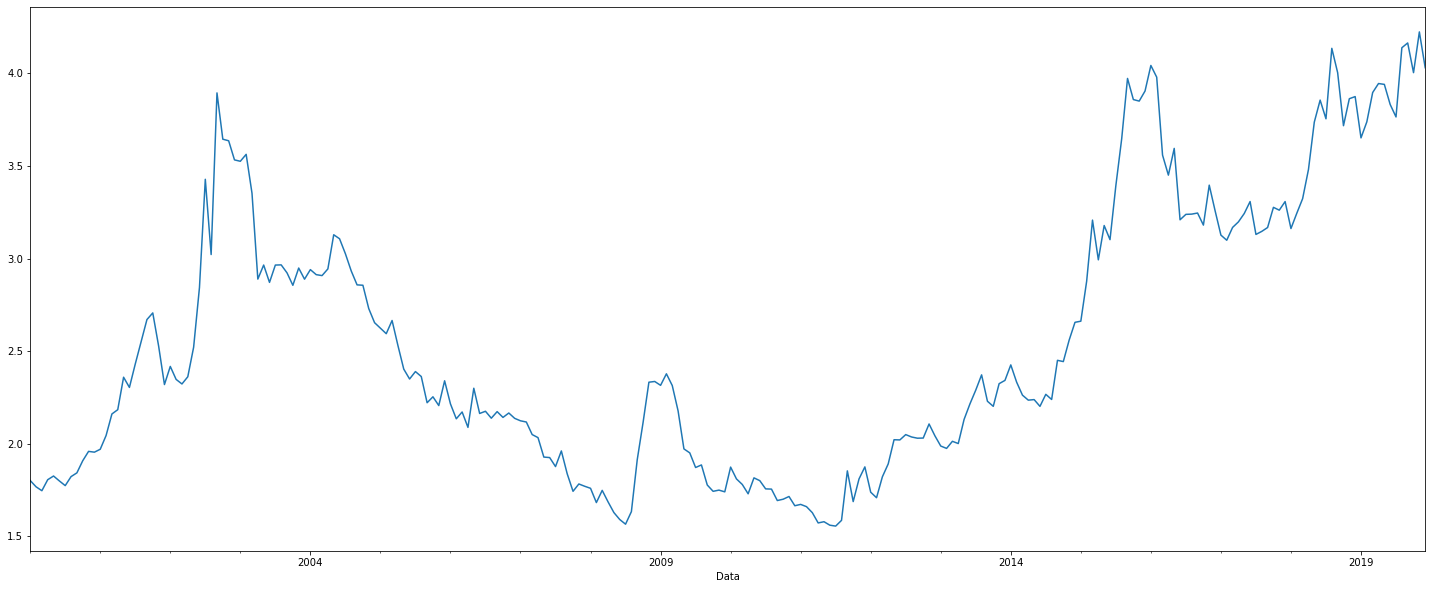

In [550]:
fig, axs = plt.subplots(figsize=(25,10))
cambio_filtrado['Cambio'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

## Teste da Raiz Unitária para a Taxa de Cambio #

In [551]:
adf_test(cambio_filtrado["Cambio"])

Results of Dickey-Fuller Test:
Test Statistic                  -0.927591
p-value                          0.778750
#Lags Used                       7.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


### Para o Teste ADF, o valor da estatística de teste ficou em -0,92, fora da região crítica. Nesse caso, falhamos em rejeitar a hipótese nula que, para o teste ADF é de existir 1 raíz unitária. Sendo assim, há evidências de uma raíz unitária na série de câmbio. ###

In [552]:
kpss_test(cambio_filtrado['Cambio'])

Results of KPSS Test:
Test Statistic            0.750654
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, dado que a hipótese nula é de não possuir uma raíz unitária e para a estatística do teste de 0,75, rejeitamos a hipótese nula para todos os valores críticos e, assim, podemos concluir que a série é não estacionária ###

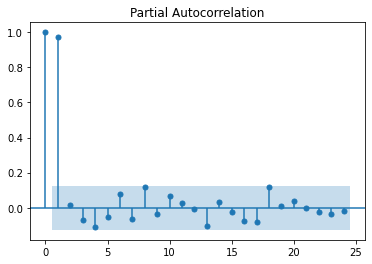

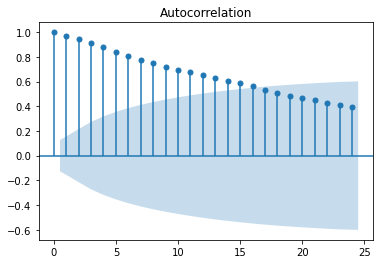

In [553]:
pacf_cambio = plot_pacf(cambio_filtrado['Cambio'])
acf_cambio = plot_acf(cambio_filtrado['Cambio'])

## 3. Taxa Selic ##


In [554]:
## Disponível em: https://www3.bcb.gov.br/sgspub/consultarvalores/consultarValoresSeries.do?method=getPagina ##

In [555]:
selic = pd.read_csv('selic.csv', sep = ';', parse_dates=['Data'])

In [556]:
selic

,Data,"Taxa de juros - Over / Selic - acumulada no mês - (% a.m.) - Banco Central do Brasil, Boletim, Seção mercado financeiro e de capitais (Bacen/Boletim/M. Finan.) - BM12_TJOVER12",Unnamed: 2
0,1974-01-01,"1,46",NaN
1,1974-02-01,"1,15",NaN
2,1974-03-01,"1,16",NaN
3,1974-04-01,"1,21",NaN
4,1974-05-01,"1,24",NaN
...,...,...,...
589,2023-02-01,"0,92",NaN
590,2023-03-01,"1,17",NaN
591,2023-04-01,"0,92",NaN
592,2023-05-01,"1,12",NaN


In [557]:
selic = selic.rename(columns={selic.columns[1]: 'Selic'})
selic

,Data,Selic,Unnamed: 2
0,1974-01-01,"1,46",NaN
1,1974-02-01,"1,15",NaN
2,1974-03-01,"1,16",NaN
3,1974-04-01,"1,21",NaN
4,1974-05-01,"1,24",NaN
...,...,...,...
589,2023-02-01,"0,92",NaN
590,2023-03-01,"1,17",NaN
591,2023-04-01,"0,92",NaN
592,2023-05-01,"1,12",NaN


In [558]:
selic = selic.drop('Unnamed: 2', axis = 1)

In [559]:
selic

,Data,Selic
0,1974-01-01,"1,46"
1,1974-02-01,"1,15"
2,1974-03-01,"1,16"
3,1974-04-01,"1,21"
4,1974-05-01,"1,24"
...,...,...
589,2023-02-01,"0,92"
590,2023-03-01,"1,17"
591,2023-04-01,"0,92"
592,2023-05-01,"1,12"


In [560]:
selic.dtypes

Data     datetime64[ns]
Selic            object
dtype: object

In [561]:
selic["Selic"] = selic["Selic"].astype(str)
selic['Selic'] = selic['Selic'].apply(lambda x: str(x.replace(".","").replace(",",".")))

In [562]:
selic
selic.dtypes

Data     datetime64[ns]
Selic            object
dtype: object

In [563]:
selic["Selic"] = selic["Selic"].astype(float)
selic.dtypes

Data     datetime64[ns]
Selic           float64
dtype: object

In [564]:
selic

,Data,Selic
0,1974-01-01,1.46
1,1974-02-01,1.15
2,1974-03-01,1.16
3,1974-04-01,1.21
4,1974-05-01,1.24
...,...,...
589,2023-02-01,0.92
590,2023-03-01,1.17
591,2023-04-01,0.92
592,2023-05-01,1.12


In [565]:
selic.dtypes

Data     datetime64[ns]
Selic           float64
dtype: object

In [566]:
selic = selic.set_index('Data')

In [567]:
selic

,Selic
Data,
1974-01-01,1.46
1974-02-01,1.15
1974-03-01,1.16
1974-04-01,1.21
1974-05-01,1.24
...,...
2023-02-01,0.92
2023-03-01,1.17
2023-04-01,0.92


In [568]:
import datetime
data_inicio = datetime.datetime(2000, 1, 1)
data_final = datetime.datetime(2020, 1, 1)

selic_filtrado = selic[(data_inicio <= selic.index) &  (data_final > selic.index)]

In [569]:
selic_filtrado

,Selic
Data,
2000-01-01,1.46
2000-02-01,1.45
2000-03-01,1.45
2000-04-01,1.30
2000-05-01,1.49
...,...
2019-08-01,0.50
2019-09-01,0.46
2019-10-01,0.48


## Gráfico SELIC ##

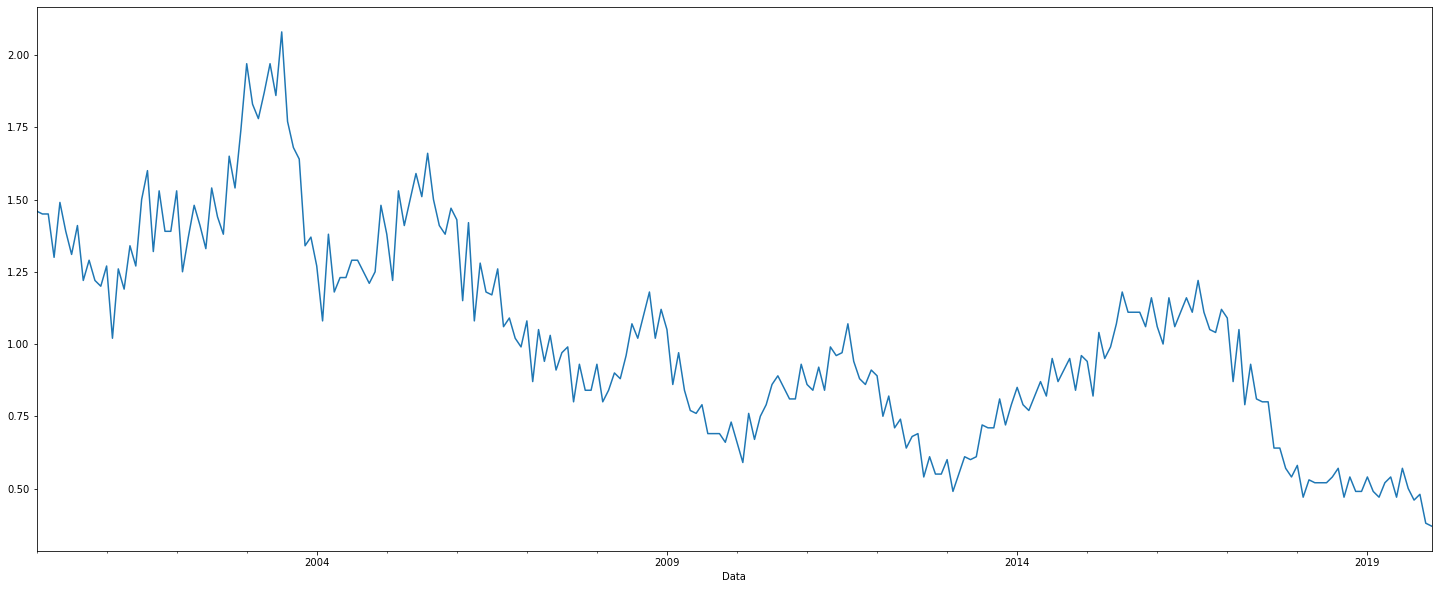

In [570]:
fig, axs = plt.subplots(figsize=(25,10))
selic_filtrado['Selic'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

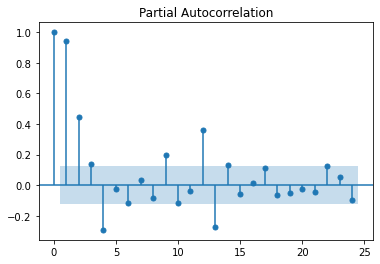

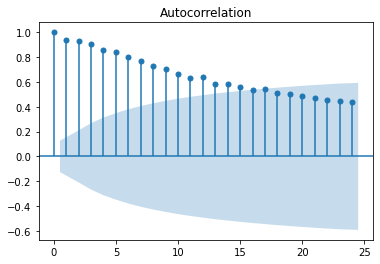

In [571]:
pacf_selic = plot_pacf(selic_filtrado['Selic'])
acf_selic = plot_acf(selic_filtrado['Selic'])

In [572]:
adf_test(selic_filtrado["Selic"])
kpss_test(selic_filtrado['Selic'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.023531
p-value                          0.744586
#Lags Used                      12.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.516184
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## 4. IBOVESPA ##

In [573]:
### Disponível em: https://br.investing.com/indices/bovespa-historical-data ###

In [574]:
ibov = pd.read_csv('ibov.csv', sep = ',', encoding = 'utf-8')

In [575]:
ibov

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.06.2023,118.087,108.339,120.519,108.335,"262,94M","9,00%"
1,01.05.2023,108.335,104.431,111.706,101.064,"288,76M","3,74%"
2,01.04.2023,104.432,101.883,108.277,99.898,"218,34M","2,50%"
3,01.03.2023,101.882,104.933,106.724,96.997,"327,02M","-2,91%"
4,01.02.2023,104.932,113.430,113.598,104.932,"228,72M","-7,49%"
...,...,...,...,...,...,...,...
284,01.10.1999,11.700,11.105,11.826,10.796,"10,69B","5,35%"
285,01.09.1999,11.106,10.583,11.735,10.583,"13,67B","5,12%"
286,01.08.1999,10.565,10.441,10.726,9.579,"13,34B","1,18%"
287,01.07.1999,10.442,11.634,11.996,10.345,"9,61B","-10,19%"


In [576]:
ibov = ibov.drop(['Último', 'Máxima', 'Mínima', 'Vol.', 'Var%'],axis = 1)

In [577]:
ibov

,Data,Abertura
0,01.06.2023,108.339
1,01.05.2023,104.431
2,01.04.2023,101.883
3,01.03.2023,104.933
4,01.02.2023,113.430
...,...,...
284,01.10.1999,11.105
285,01.09.1999,10.583
286,01.08.1999,10.441
287,01.07.1999,11.634


In [578]:
ibov.dtypes

Data         object
Abertura    float64
dtype: object

In [579]:
ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')

In [580]:
ibov.dtypes

Data        datetime64[ns]
Abertura           float64
dtype: object

In [581]:
ibov = ibov.set_index('Data')

In [582]:
data_inicio = datetime.datetime(2000, 1, 1)
data_final = datetime.datetime(2020, 1, 1)

ibov_filtrado = ibov[(data_inicio <= ibov.index) &  (data_final > ibov.index)]

In [583]:
ibov_filtrado

,Abertura
Data,
2019-12-01,108.233
2019-11-01,107.221
2019-10-01,104.745
2019-09-01,101.133
2019-08-01,101.819
...,...
2000-05-01,15.596
2000-04-01,17.826
2000-03-01,17.668


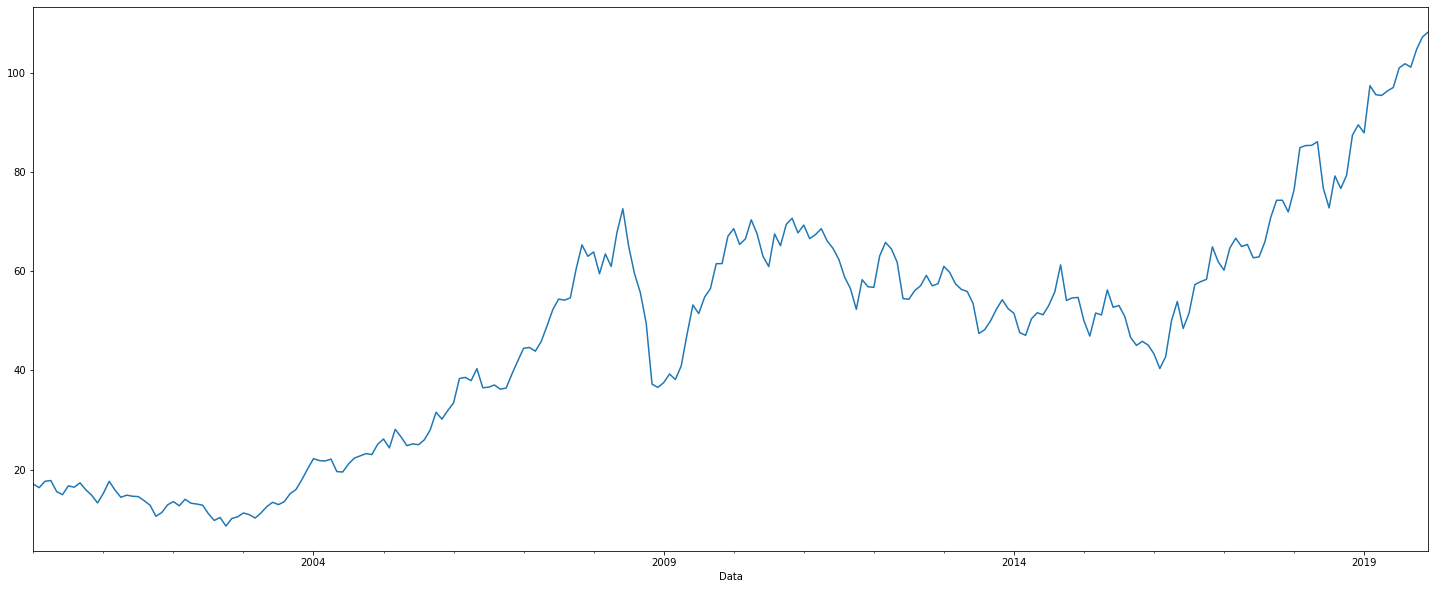

In [584]:
fig, axs = plt.subplots(figsize=(25,10))
ibov_filtrado['Abertura'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

### Testes de Raíz Unitária ###

In [585]:
adf_test(ibov_filtrado["Abertura"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.991682
p-value                          0.290232
#Lags Used                       3.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


### Para o teste ADF, o valor da estatística do teste é de -1.99, o que nos deixa fora da região crítica para todos os valores. Sendo assim, falhamos em rejeitar a hipótese nula, o que indica uma raíz unitária na série. ###

In [586]:
kpss_test(ibov_filtrado['Abertura'])

Results of KPSS Test:
Test Statistic            1.778153
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, com o valor da estatística do teste de 1,77, dado que está dentro da região crítica para todas as significâncias, rejeitamos a hipótese nula, que é de não haver raíz unitária ###

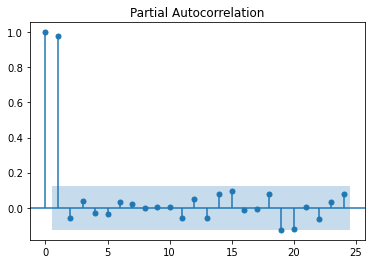

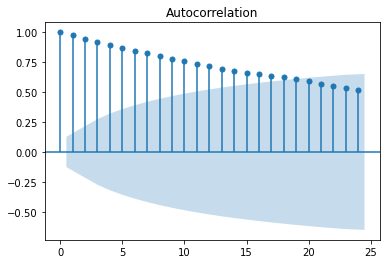

In [587]:
pacf_ibov = plot_pacf(ibov_filtrado['Abertura'])
acf_ibov = plot_acf(ibov_filtrado['Abertura'])

## 5. EMBI - Risco Brasil ##

In [588]:
### Disponível em: http://www.ipeadata.gov.br/Default.aspx ###

In [589]:
embi = pd.read_csv('embi.csv', sep = ';', parse_dates=['Data'], encoding='utf-8')

In [590]:
embi

,Data,EMBI + Risco-Brasil - - - JP Morgan - JPM366_EMBI366,Unnamed: 2
0,1994-04-01,NaN,NaN
1,1994-05-01,24072.0,NaN
2,1994-06-01,24339.0,NaN
3,1994-07-01,22286.0,NaN
4,1994-08-01,21069.0,NaN
...,...,...,...
346,2023-02-01,4753.0,NaN
347,2023-03-01,5971.0,NaN
348,2023-04-01,5141.0,NaN
349,2023-05-01,5574.0,NaN


In [591]:
embi = embi.drop('Unnamed: 2', axis = 1)

In [592]:
embi

,Data,EMBI + Risco-Brasil - - - JP Morgan - JPM366_EMBI366
0,1994-04-01,NaN
1,1994-05-01,24072.0
2,1994-06-01,24339.0
3,1994-07-01,22286.0
4,1994-08-01,21069.0
...,...,...
346,2023-02-01,4753.0
347,2023-03-01,5971.0
348,2023-04-01,5141.0
349,2023-05-01,5574.0


In [593]:
embi = embi.rename(columns={embi.columns[1]:'Embi'})

In [594]:
embi

,Data,Embi
0,1994-04-01,NaN
1,1994-05-01,24072.0
2,1994-06-01,24339.0
3,1994-07-01,22286.0
4,1994-08-01,21069.0
...,...,...
346,2023-02-01,4753.0
347,2023-03-01,5971.0
348,2023-04-01,5141.0
349,2023-05-01,5574.0


In [595]:
embi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    351 non-null    datetime64[ns]
 1   Embi    350 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


In [596]:
embi = embi.dropna(inplace = False, axis = 0)

In [597]:
embi

,Data,Embi
1,1994-05-01,24072.0
2,1994-06-01,24339.0
3,1994-07-01,22286.0
4,1994-08-01,21069.0
5,1994-09-01,16989.0
...,...,...
346,2023-02-01,4753.0
347,2023-03-01,5971.0
348,2023-04-01,5141.0
349,2023-05-01,5574.0


In [598]:
embi.dtypes

Data    datetime64[ns]
Embi           float64
dtype: object

In [599]:
embi

,Data,Embi
1,1994-05-01,24072.0
2,1994-06-01,24339.0
3,1994-07-01,22286.0
4,1994-08-01,21069.0
5,1994-09-01,16989.0
...,...,...
346,2023-02-01,4753.0
347,2023-03-01,5971.0
348,2023-04-01,5141.0
349,2023-05-01,5574.0


In [600]:
embi = embi.set_index('Data')

In [601]:
embi

,Embi
Data,
1994-05-01,24072.0
1994-06-01,24339.0
1994-07-01,22286.0
1994-08-01,21069.0
1994-09-01,16989.0
...,...
2023-02-01,4753.0
2023-03-01,5971.0
2023-04-01,5141.0


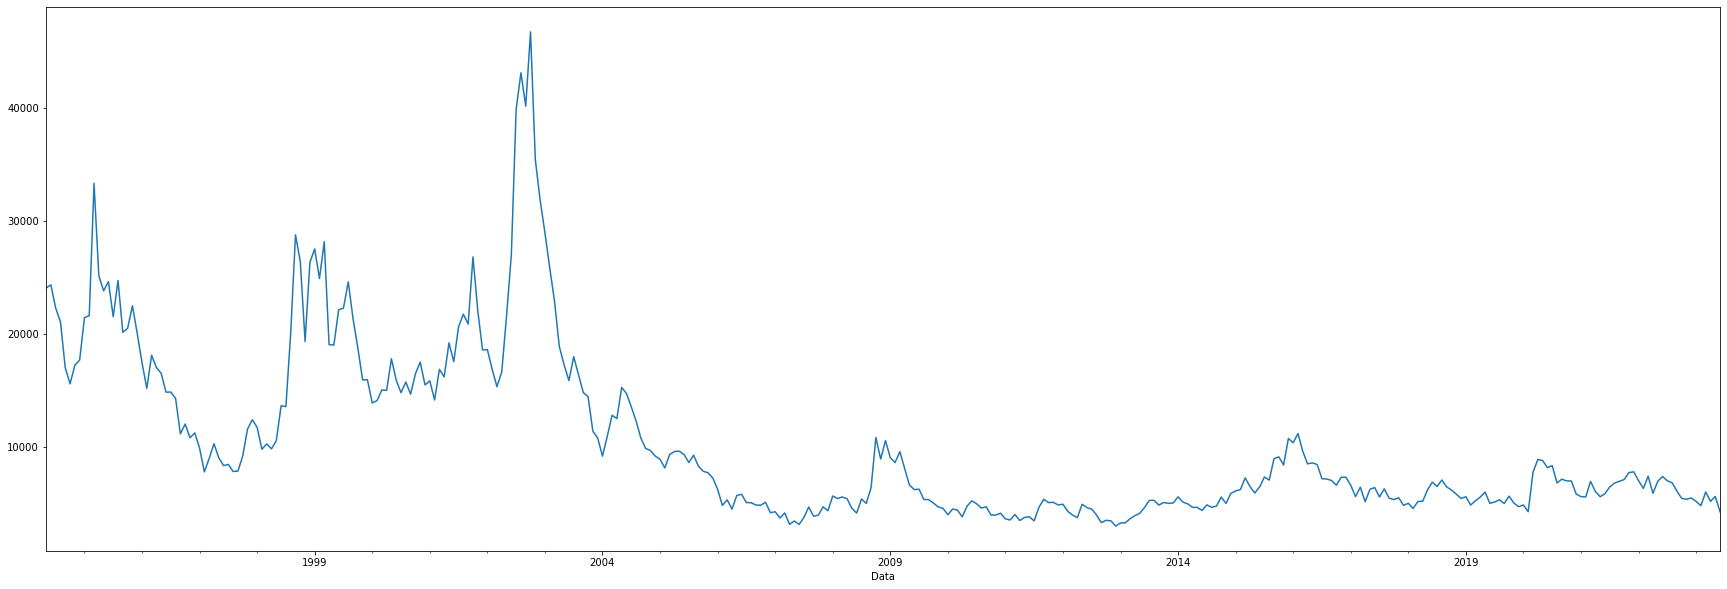

In [602]:
fig, axs = plt.subplots(figsize=(30,10))
embi['Embi'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

In [603]:
data_inicio = datetime.datetime(2000, 1, 1)
data_final = datetime.datetime(2020, 1, 1)

embi_filtrado = embi[(data_inicio <= embi.index) &  (data_final > embi.index)]

In [604]:
embi_filtrado

,Embi
Data,
2000-01-01,13865.0
2000-02-01,14081.0
2000-03-01,15016.0
2000-04-01,14988.0
2000-05-01,17790.0
...,...
2019-08-01,5278.0
2019-09-01,4942.0
2019-10-01,5601.0


In [605]:
embi_filtrado_log = np.log(embi_filtrado['Embi'])

In [606]:
embi_filtrado_log

Data
2000-01-01    9.537123
2000-02-01    9.552582
2000-03-01    9.616872
2000-04-01    9.615005
2000-05-01    9.786392
                ...   
2019-08-01    8.571303
2019-09-01    8.505525
2019-10-01    8.630700
2019-11-01    8.515792
2019-12-01    8.447629
Name: Embi, Length: 240, dtype: float64

In [607]:
df_embi_log = embi_filtrado_log.to_frame()

In [608]:
df_embi_log

,Embi
Data,
2000-01-01,9.537123
2000-02-01,9.552582
2000-03-01,9.616872
2000-04-01,9.615005
2000-05-01,9.786392
...,...
2019-08-01,8.571303
2019-09-01,8.505525
2019-10-01,8.630700


### Gráfico em LOG para série do EMBI ###

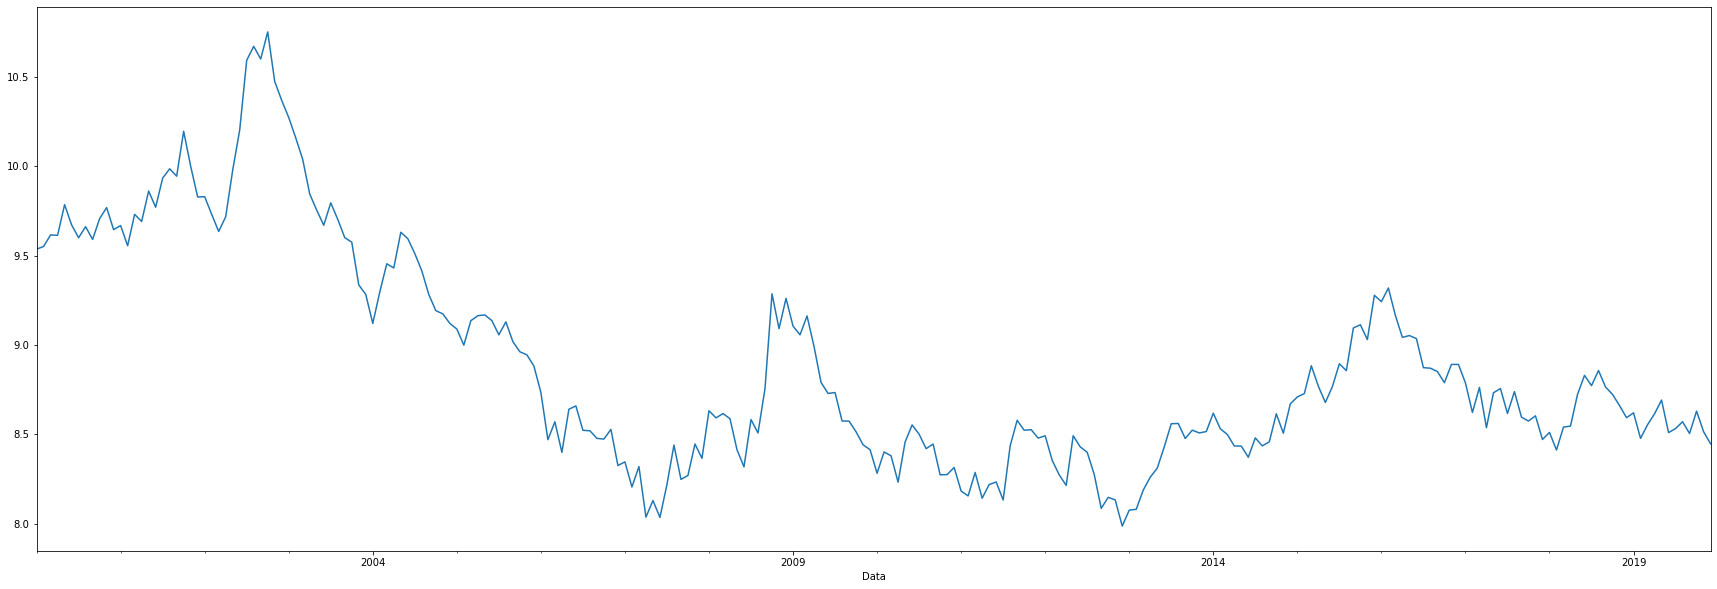

In [609]:
fig, axs = plt.subplots(figsize=(30,10))
df_embi_log['Embi'].plot(ax=axs)
axs.set_xlabel('Data')
plt.show()

In [610]:
adf_test(df_embi_log["Embi"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.894509
p-value                          0.334649
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


### Para o teste ADF, para os valores críticos a níveis de 10 e 5%, rejeitamos a hipotese nula de uma raíz unitária e, para 1% falhamos em rejeitar a hipótese nula, indicando a existência de uma raíz unitária ###

In [611]:
kpss_test(df_embi_log['Embi'])

Results of KPSS Test:
Test Statistic            1.16169
p-value                   0.01000
Lags Used                10.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Para o teste KPSS, rejeitamos a hipótese nula da série ser estacionária, indicando a existência de uma raíz unitária ###

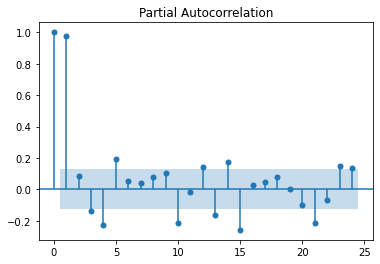

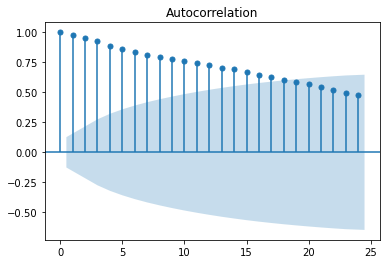

In [612]:
pacf_embi = plot_pacf(df_embi_log['Embi'])
acf_embi = plot_acf(df_embi_log['Embi'])

## Implementando modelo VAR ##

## Criando apenas um dataframe para todas as séries ##


In [613]:
df_embi_log['Balanca'] = df_balanca_dess_filtrado["Saldo"]

In [614]:
df_embi_log['Cambio'] = cambio_filtrado['Cambio']

In [615]:
df_embi_log['Selic'] = selic_filtrado['Selic']

In [616]:
df_embi_log['Ibov'] = ibov_filtrado['Abertura']

In [617]:
df_embi_log

,Embi,Balanca,Cambio,Selic,Ibov
Data,,,,,
2000-01-01,9.537123,1784.442181,1.8016,1.46,17.098
2000-02-01,9.552582,949.372969,1.7677,1.45,16.389
2000-03-01,9.616872,43.387843,1.7465,1.45,17.668
2000-04-01,9.615005,-424.838476,1.8059,1.30,17.826
2000-05-01,9.786392,-551.103384,1.8258,1.49,15.596
...,...,...,...,...,...
2019-08-01,8.571303,876.522803,4.1379,0.50,101.819
2019-09-01,8.505525,2018.006747,4.1638,0.46,101.133
2019-10-01,8.630700,953.568404,4.0035,0.48,104.745


## Diferenciando as séries, dado que concluimos que todas são não estacionárias ##

In [618]:
df_differenced = df_embi_log.diff().dropna()

In [619]:
df_differenced

,Embi,Balanca,Cambio,Selic,Ibov
Data,,,,,
2000-02-01,0.015459,-835.069212,-0.0339,-0.01,-0.709
2000-03-01,0.064290,-905.985126,-0.0212,0.00,1.279
2000-04-01,-0.001866,-468.226319,0.0594,-0.15,0.158
2000-05-01,0.171387,-126.264908,0.0199,0.19,-2.230
2000-06-01,-0.113135,-428.233556,-0.0266,-0.10,-0.629
...,...,...,...,...,...
2019-08-01,0.038236,1082.094767,0.3736,-0.07,0.845
2019-09-01,-0.065777,1141.483944,0.0259,-0.04,-0.686
2019-10-01,0.125175,-1064.438344,-0.1603,0.02,3.612


## Selecionando a ordem do VAR ##

In [620]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [639]:
model = VAR(df_embi_log)

c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [641]:
model = VAR(df_embi_log)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  3.227396866170967
BIC :  3.6637730442376837
FPE :  25.21526653487194
HQIC:  3.4032444533010366 

Lag Order = 2
AIC :  2.398574570293026
BIC :  3.200990062107863
FPE :  11.011102602391132
HQIC:  2.7219623890939038 

Lag Order = 3
AIC :  2.436096319091652
BIC :  3.6067495312891644
FPE :  11.440100488906785
HQIC:  2.907943689586676 

Lag Order = 4
AIC :  2.337327341288816
BIC :  3.8784389494569904
FPE :  10.3779889547677
HQIC:  2.958562812793744 

Lag Order = 5
AIC :  2.4231798791864803
BIC :  4.336993142330058
FPE :  11.333100337178665
HQIC:  3.19474135648802 

Lag Order = 6
AIC :  2.4358001990940528
BIC :  4.724581279779709
FPE :  11.51479936159277
HQIC:  3.3586350707894446 

Lag Order = 7
AIC :  2.5364513334290324
BIC :  5.202489623737298
FPE :  12.793346230995612
HQIC:  3.6115166024705836 

Lag Order = 8
AIC :  2.653145262347281
BIC :  5.698753715759322
FPE :  14.467369276061618
HQIC:  3.881407678836787 

Lag Order = 9
AIC :  2.705487398285687
BIC :  6.13300286763

c:\Users\luizv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### A partir do critério de informação AIC, tem seu menor valor no lag 2, logo, ajustarei o modelo com esse número de desafagens ###

In [643]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jul, 2023
Time:                     21:17:20
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    3.20099
Nobs:                     238.000    HQIC:                   2.72196
Log likelihood:          -1918.97    FPE:                    11.0111
AIC:                      2.39857    Det(Omega_mle):         8.78454
--------------------------------------------------------------------
Results for equation Embi
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.344430         0.270417            1.274           0.203
L1.Embi            0.861517         0.082500           10.443           0.000
L1.Balanca        -0.000012         0.000007           -1.678           0

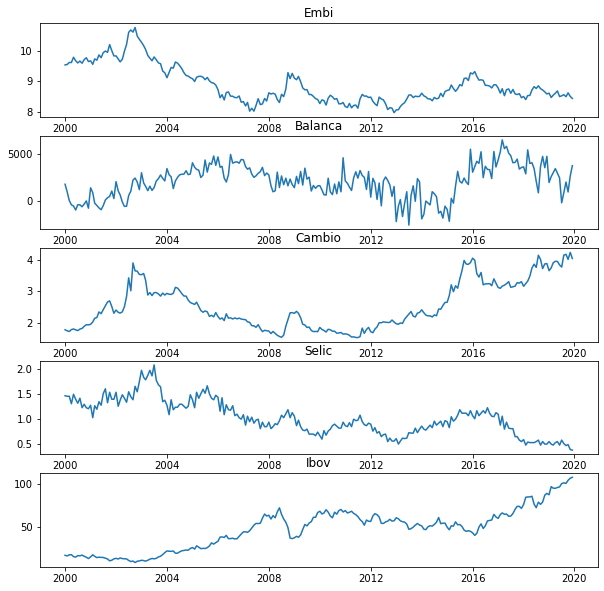

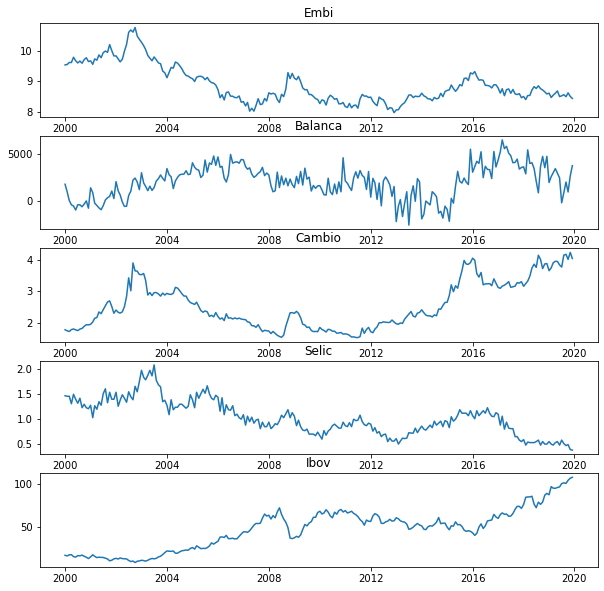

In [644]:
results.plot()

## Fazendo o teste de COINTEGRAÇÃO para definir se seguiremos com o VAR ou VEC ##

In [661]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [653]:
print(result_coin)

In [655]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [656]:
joh_model3 = coint_johansen(df_embi_log,0,2) 
joh_output(joh_model3)


   max_eig_stat  trace_stat
0     30.849264   71.071107
1     24.230349   40.221843
2      7.672181   15.991494
3      7.323149    8.319313
4      0.996164    0.996164 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [662]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,0,2)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_embi_log)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Embi   ::  71.07     > 69.8189   =>   True
Balanca ::  40.22     > 47.8545   =>   False
Cambio ::  15.99     > 29.7961   =>   False
Selic  ::  8.32      > 15.4943   =>   False
Ibov   ::  1.0       > 3.8415    =>   False
